<a href="https://colab.research.google.com/github/SM24-Industrial-Software-Dev/ML-forecasting-NOx-levels/blob/ES-33-forecaster/Forecaster_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup code here

#### Fetches required code from our Github repo

In [1]:
!git clone https://github.com/SM24-Industrial-Software-Dev/ML-forecasting-NOx-levels
!cp ML-forecasting-NOx-levels/API/receive_conc_api.py .
!cp ML-forecasting-NOx-levels/msa.py .
!cp ML-forecasting-NOx-levels/forecaster.py .

Cloning into 'ML-forecasting-NOx-levels'...
remote: Enumerating objects: 253, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 253 (delta 43), reused 16 (delta 16), pack-reused 166
Receiving objects: 100% (253/253), 3.21 MiB | 6.94 MiB/s, done.
Resolving deltas: 100% (113/113), done.


#### Pip installs

In [ ]:
!pip install git+https://github.com/rameshnatarajanus/sts-jax@get-fit_hmc-to-work
!pip install pycrs

#### Required imports

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import jax.numpy as jnp
import jax.random as jr
import sts_jax.structural_time_series as sts
import ee
from google.colab import userdata

from msa import MSA
from receive_conc_api import get_Data
from forecaster import NOxForecaster

#### Earth Engine authentication and MSA initialization

In [4]:
credentials = ee.ServiceAccountCredentials("yeshiva-summer-2024-1@yu-summer-2024.iam.gserviceaccount.com", key_data=userdata.get('GCP_CREDENTIALS'))
ee.Initialize(credentials = credentials, project='yu-summer-2024', opt_url='https://earthengine-highvolume.googleapis.com')

msa = MSA()

#### Holiday functions

In [5]:
import holidays
import dateutil.easter

def get_custom_holidays(years):
    custom_holidays = holidays.HolidayBase()
    for year in years:
        easter = dateutil.easter.easter(year)
        custom_holidays.append({
            easter: "Easter",
        })
    return custom_holidays

def get_holidays_in_range(start_date, end_date):
    """
    Gets a list of holidays within a given date range.

    Args:
        start_date (datetime): The start date of the range.
        end_date (datetime): The end date of the range.

    Returns:
        list: A list of tuples, where each tuple contains a pandas Timestamp representing the holiday date
              and the corresponding holiday name.
    """
    years = range(start_date.year, end_date.year + 1)
    us_holidays = holidays.US(years=years) + get_custom_holidays(years)
    return [(pd.Timestamp(date), name) for date, name in us_holidays.items()
             if start_date <= pd.Timestamp(date) <= end_date]

### Read the NOx data from the API and check it out

In [6]:
# Choose the desired MSA
AlbanyNY = 'Albany-Schenectady-Troy, NY'
# Choose the desired date range
start_date = "2024-05-01"
# end_date = "2024-07-01"

# Get the NOx data for the desired MSA and date range
# doesn't work
# df = get_Data(msa.get_msas(AlbanyNY), start_date, end_date, 0.3)
# Instead use a csv
start_date = pd.to_datetime(start_date)
df = pd.read_csv("AlbanyNY.csv")
df.rename(columns={'DATE': 'date', 'conc':'nox-concentration'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] > start_date]
df = df[['date', 'nox-concentration']]

#### Check out the data

In [7]:
display(df)

,date,nox-concentration
1524,2024-05-02,0.000032
1525,2024-05-03,0.000025
1526,2024-05-04,0.000026
1527,2024-05-06,0.000023
1528,2024-05-07,0.000017
...,...,...
1585,2024-07-10,0.000024
1586,2024-07-11,0.000027
1587,2024-07-12,0.000047
1588,2024-07-13,0.000019


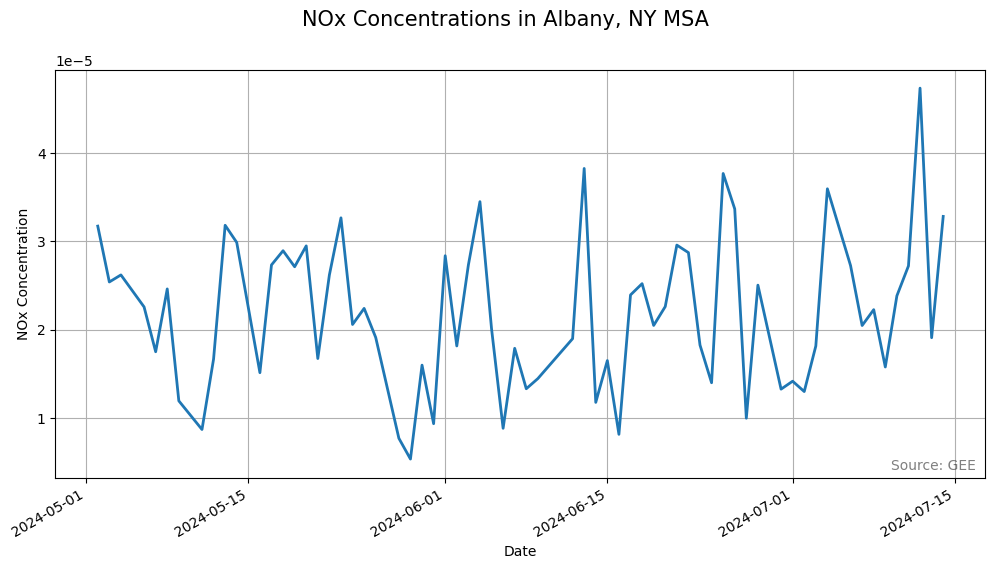

In [8]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.array(df['date'].to_numpy()),
        jnp.array(df['nox-concentration'].to_numpy(), dtype=np.float32),
        lw=2,
        label='training data',
        markersize=1)
ax.grid()

ax.set_ylabel("NOx Concentration")
ax.set_xlabel("Date")

fig.suptitle(f"NOx Concentrations in Albany, NY MSA", fontsize=15)
ax.text(
    0.99,
    0.02,
    "Source: GEE", # Add link
    transform=ax.transAxes,
    horizontalalignment='right',
    alpha=0.5
)
fig.autofmt_xdate()

### Forecast without holiday data

In [9]:
# Initialize the forecaster
f = NOxForecaster(df)

#### Plotting functions

In [10]:
def plot_forecast(f, model, param_samples, num_forecast_steps):
    # Get the time series and dates
    time_series = f.time_series.flatten()
    dates = f.dates
    forecast_dates = pd.date_range(dates.max(), periods=14)

    # Forecast
    forecast_means, forecast_scales = f.get_forecast(model, param_samples, num_forecast_steps)

    # Plot the forecast
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(dates, time_series, lw=2, label='Observation', color='C0')
    ax.plot(forecast_dates, forecast_means, lw='2', color='C1', label='Forecast')
    ax.fill_between(forecast_dates,
                    forecast_means - 2*forecast_scales, forecast_means + 2*forecast_scales,
                    color='C1', alpha=0.3)
    ax.set_ylabel("Observations and Forecasts")
    ax.set_xlabel("Date")
    ax.legend(loc='upper left')
    ax.grid()
    fig.suptitle("Observations and Forecasts", fontsize=15)

def plot_decompose(f, model, param_samples):
    # Decompose the fitted model into STS components
    component_posterior_dict = f.get_decomposition_data(model, param_samples)

    # Plot the posterior of each component
    num_components = len(component_posterior_dict)
    fig = plt.figure(figsize=(12, 4 * num_components))
    for i, (component_name, component_posterior) in enumerate(component_posterior_dict.items()):
        component_mean = component_posterior['mean']
        component_std = component_posterior['std']

        ax = fig.add_subplot(num_components, 1,1+i)
        ax.plot(f.dates, component_mean, lw=2, color='C0')
        ax.fill_between(f.dates, component_mean-2.*component_std, component_mean+2.*component_std, alpha=0.5, color='C1')
        ax.set_title(component_name)

#### Forecast

In [11]:
# Tuples of models with their optimal parameters
d = f.fit_dummy_seasonal_model()
t = f.fit_trig_seasonal_model()

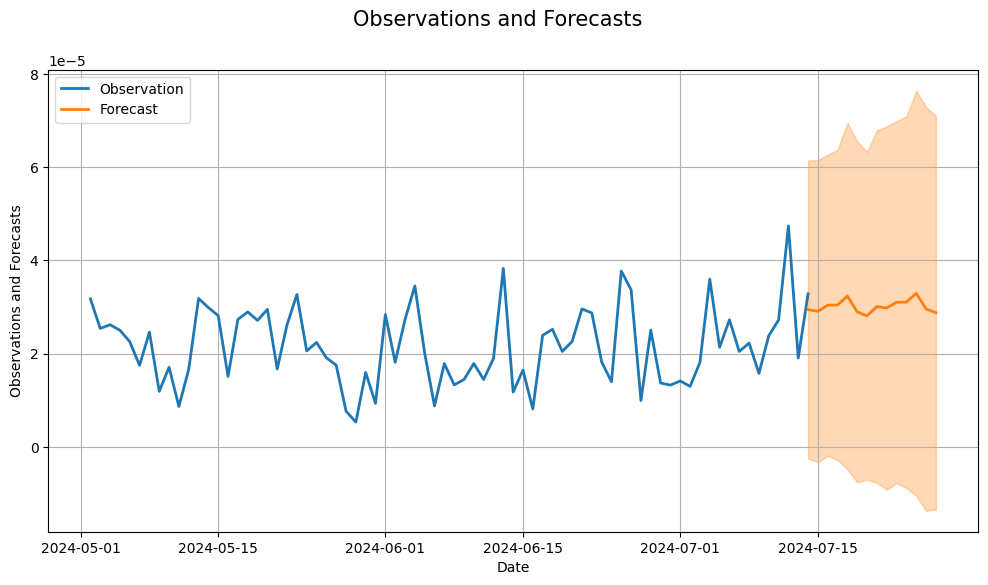

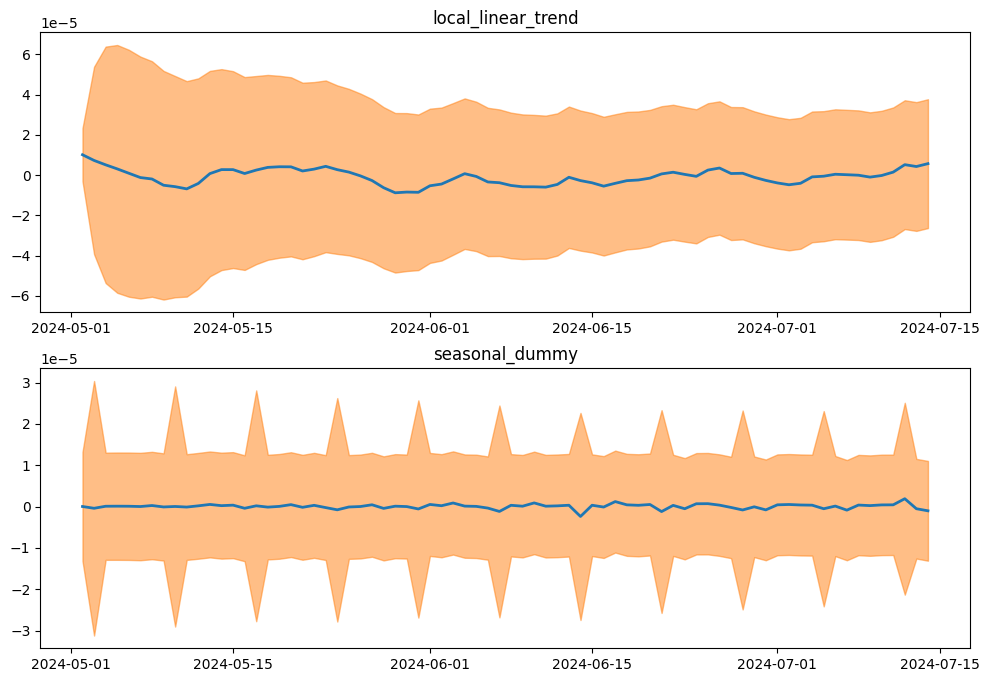

In [12]:
# Model with a dummy seasonal component
plot_forecast(f, *d, 14)
plot_decompose(f, *d)

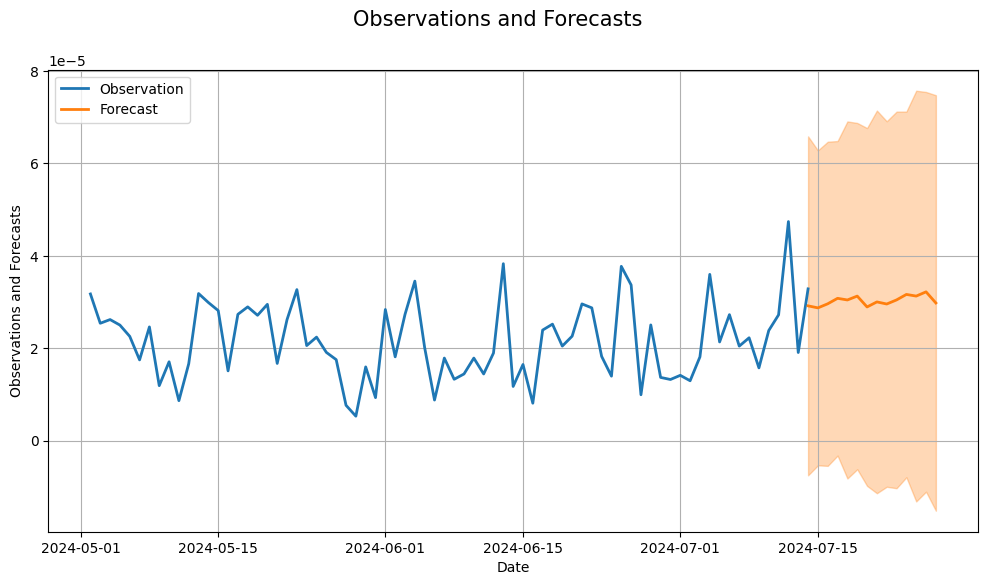

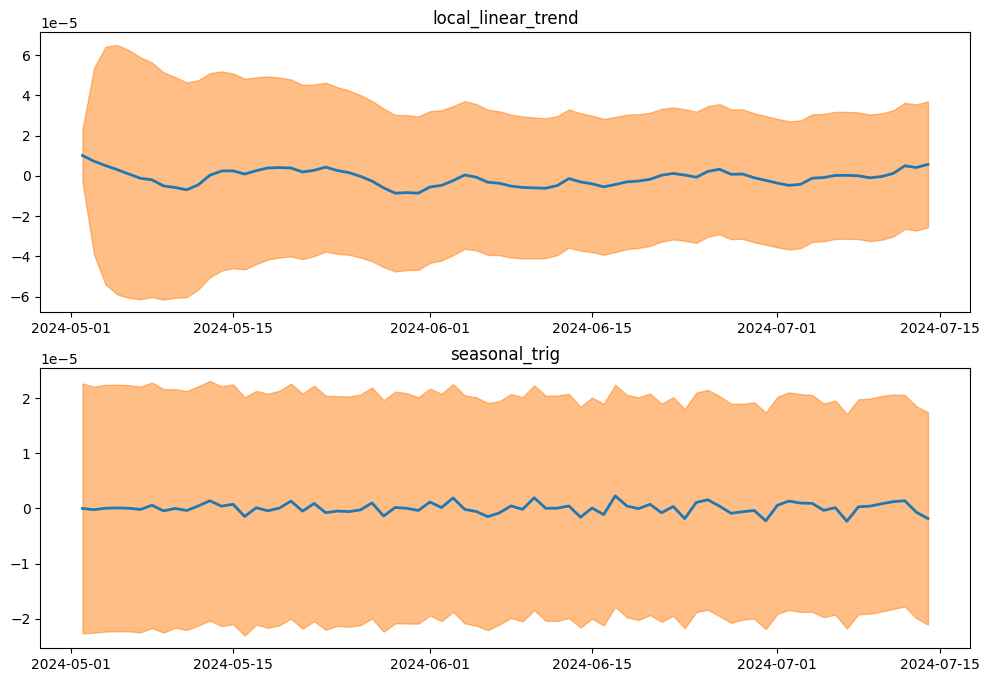

In [13]:
# Model with a trigonometric seasonal component
plot_forecast(f, *t, 14)
plot_decompose(f, *t)

### Forecast with holiday data

In [19]:
# Create a Series filled with 0s
df = NOxForecaster.fill_df(df)
dates = df['date']
start_date = dates.min()
end_date = dates.max()
holidays_in_range = get_holidays_in_range(start_date, end_date)
isholiday = pd.Series(0, index=dates)
# Set 1 for holiday dates
for holiday_date, _ in holidays_in_range:
    isholiday[holiday_date] = 1
isholiday.index = df.index
df['isholiday'] = isholiday

# Initialize the forecaster
f2 = NOxForecaster(df)

# # View the DataFrame with the added holiday data
# display(df)

#### Plotting functions

In [15]:
def plot_forecast_with_covariates(f, model, param_samples, num_forecast_steps):
    # Get the time series, dates, and holidays
    time_series = f.time_series.flatten()
    dates = f.dates
    last_date = dates.max()
    forecast_dates = pd.date_range(last_date, periods=num_forecast_steps)
    forecast_holidays = get_holidays_in_range(pd.to_datetime(last_date), forecast_dates.max())

    # Create a new Series filled with 0s
    isholiday = pd.Series(0, index=forecast_dates)
    # Set 1 for holiday dates
    for holiday_date, _ in forecast_holidays:
        isholiday[holiday_date] = 1
    # Forecast
    forecast_means, forecast_scales = f.get_forecast(model, param_samples, holidays=isholiday.values)
    # Plot the forecast
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(dates, time_series, lw=2, label='Observation', color='C0')
    ax.plot(forecast_dates, forecast_means, lw='2', color='C1', label='Forecast')
    ax.fill_between(forecast_dates,
                    forecast_means - 2*forecast_scales, forecast_means + 2*forecast_scales,
                    color='C1', alpha=0.3)

    # plot vertical lines for holidays
    all_holidays = np.concatenate([f.holidays.flatten(), isholiday.values])
    all_dates = np.concatenate([dates, forecast_dates])
    holidays_in_range = all_dates[all_holidays == 1]
    for holiday_date in holidays_in_range:
      ax.axvline(x = holiday_date, linestyle = '--', color = 'purple')

    ax.set_ylabel("Observations and Forecasts")
    ax.set_xlabel("Date")
    ax.legend(loc='upper left')
    ax.grid()
    fig.suptitle("Observations and Forecasts", fontsize=15)

def plot_decompose(f, model, param_samples):
    # Decompose the fitted model into STS components
    component_posterior_dict = f.get_decomposition_data(model, param_samples)

    # Plot the posterior of each component
    num_components = len(component_posterior_dict)
    fig = plt.figure(figsize=(12, 4 * num_components))
    for i, (component_name, component_posterior) in enumerate(component_posterior_dict.items()):
        component_mean = component_posterior['mean']
        component_std = component_posterior['std']

        ax = fig.add_subplot(num_components, 1,1+i)
        ax.plot(f.dates, component_mean, lw=2, color='C0')
        ax.fill_between(f.dates, component_mean-2.*component_std, component_mean+2.*component_std, alpha=0.5, color='C1')
        ax.set_title(component_name)

#### Forecast

In [16]:
# Tuples of models with their optimal parameters
d2 = f2.fit_dummy_seasonal_model()
t2 = f2.fit_trig_seasonal_model()

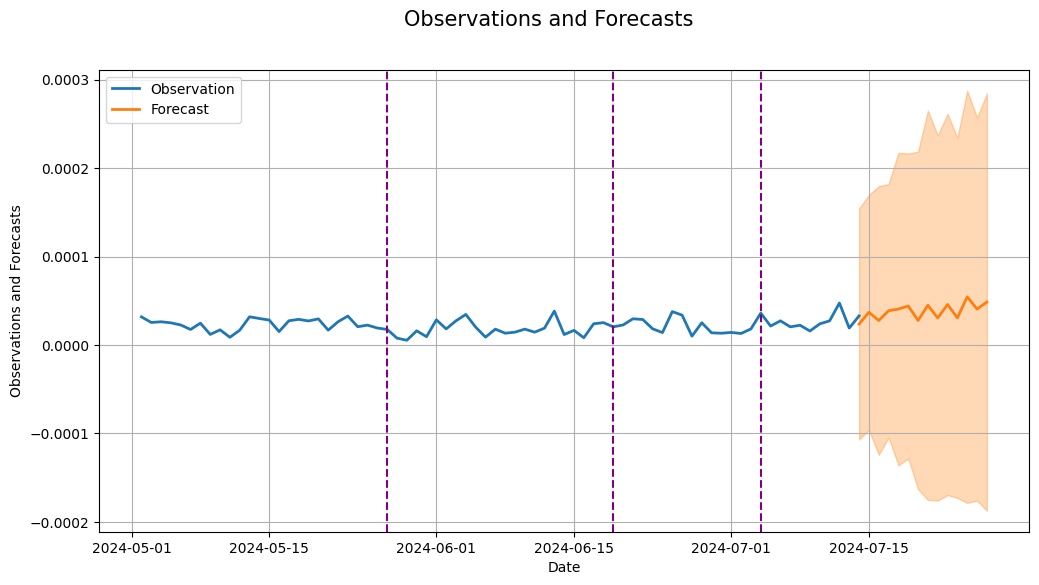

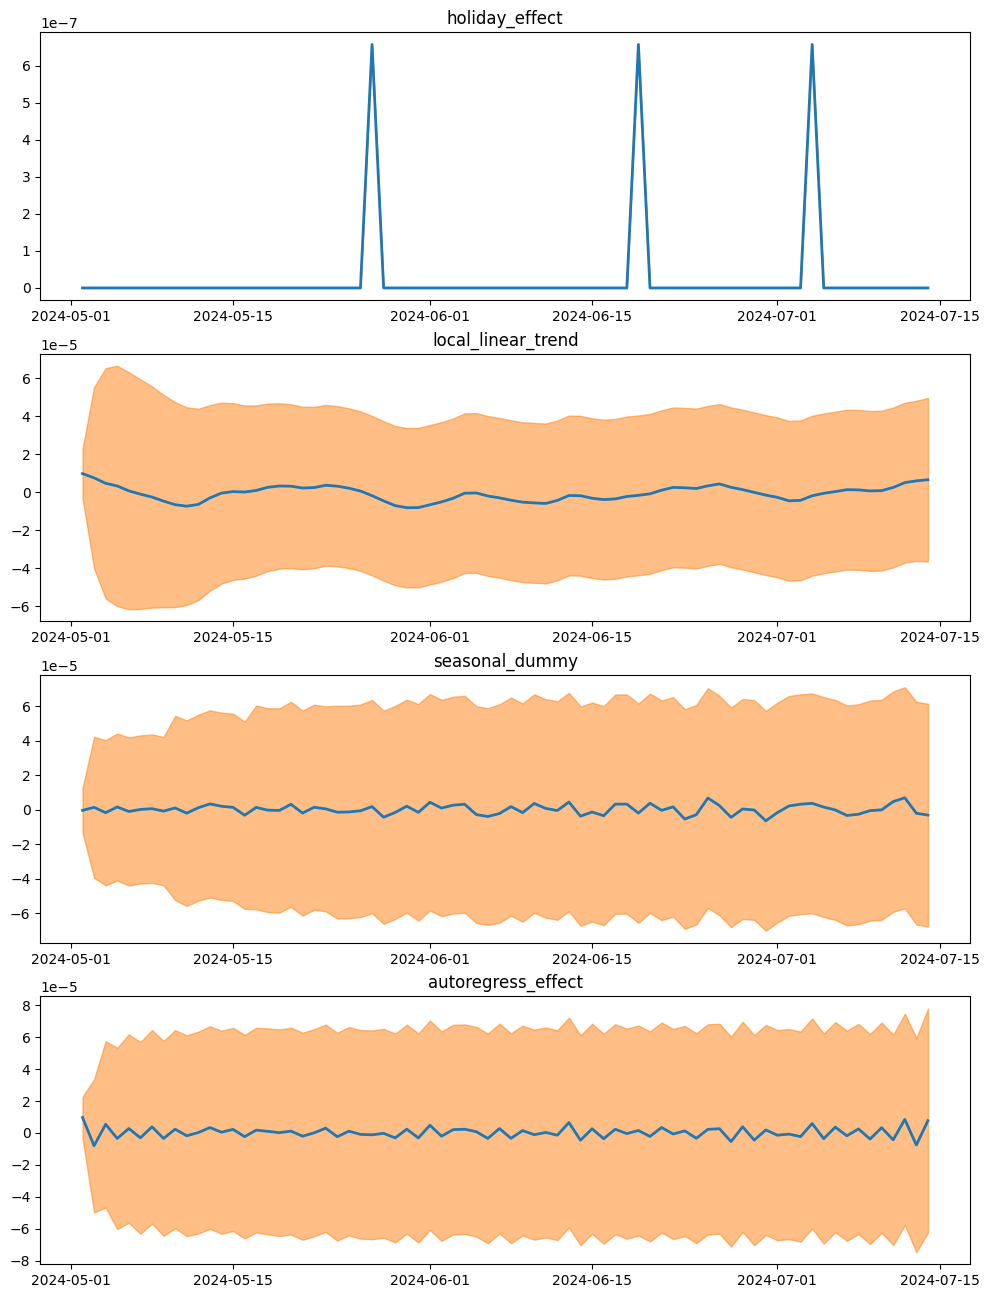

In [17]:
# Model with a dummy seasonal component
plot_forecast_with_covariates(f2, *d2, 14)
plot_decompose(f2, *d2)

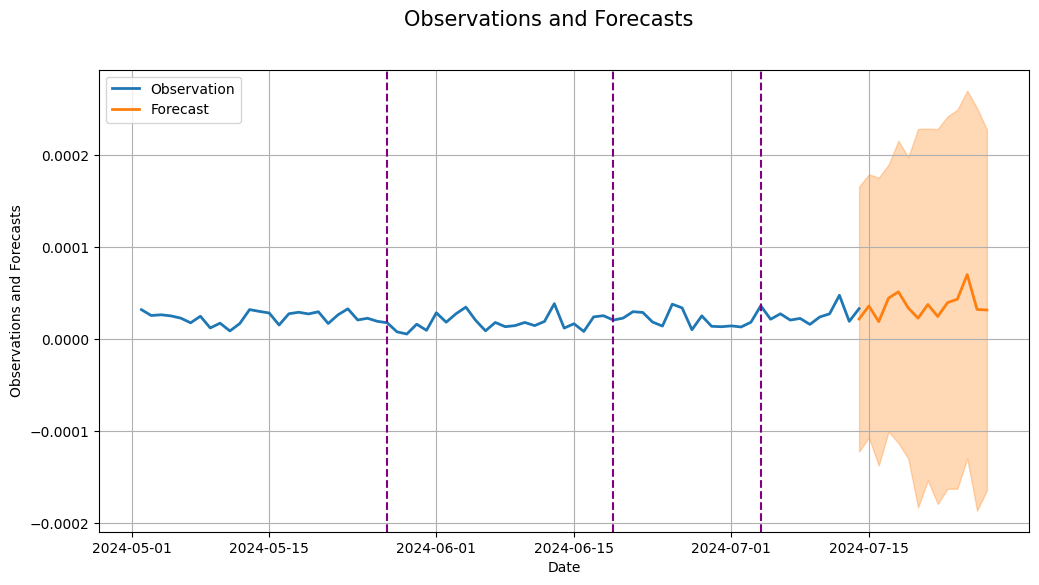

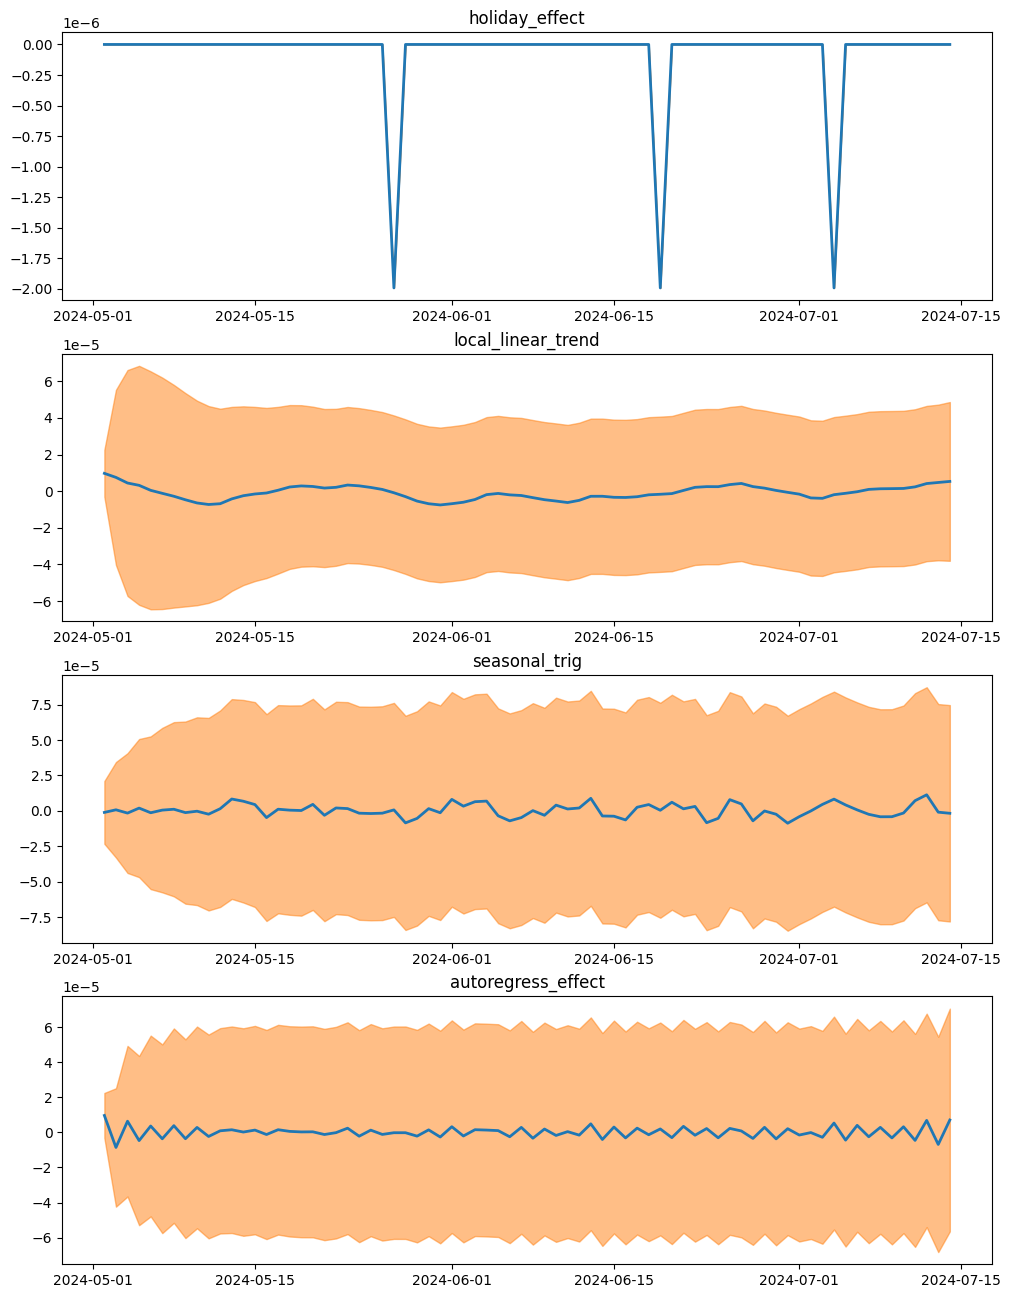

In [18]:
# Model with a trigonometric seasonal component
plot_forecast_with_covariates(f2, *t2, 14)
plot_decompose(f2, *t2)